# Algorithm to mix multiple pixels to match rgb value

In [12]:
#!/usr/local/bin/python3

import numpy as np
from PIL import Image, ImageCms
import PIL

# Open image and discard alpha channel which makes wheel round rather than square
im = Image.open('./motive/muschel/aliger gigas3.jpg').convert('RGB')

# Convert to Lab colourspace
srgb_p = ImageCms.createProfile("sRGB")
lab_p  = ImageCms.createProfile("LAB")

rgb2lab = ImageCms.buildTransformFromOpenProfiles(srgb_p, lab_p, "RGB", "LAB")
Lab = ImageCms.applyTransform(im, rgb2lab)

In [8]:
rgb2lab

In [10]:
ImageCms.applyTransform(im, rgb2lab)

<PIL.Image.Image image mode=LAB size=640x452>

In [19]:


PIL.ImageColor.getcolor("#ff0000",'L')

76

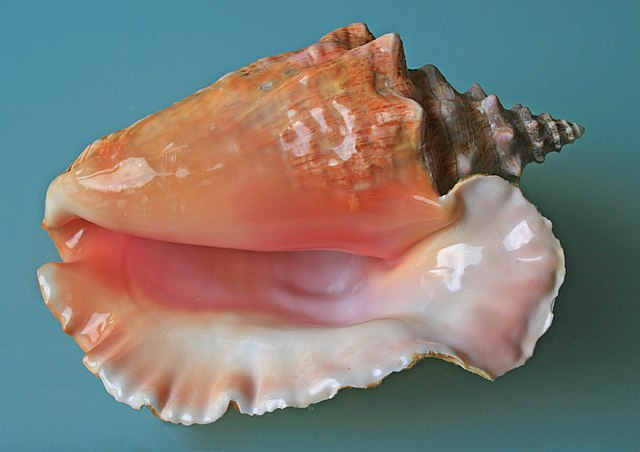

In [9]:
im

In [6]:
L, a, b = Lab.split()

L.save('L.png')
a.save('a.png')
b.save('b.png')

In [4]:
#
def matchRGB(rgb:tuple,rgb_background:tuple,patchesList:list)->tuple:
    """
    Inputs:
    - patchesList: contains tuple containing (i) rgb value tuple of patch and (ii) area of patch, where area must be relative to background area s.t. sum over patches of area <=1
    """
    r,g,b = rgb
    r_b,g_b,b_b = rgb_background
    # approximate rgb as good as possible // solve underdetermined system of eq.

    area_background = 1-sum([area_patch*1 for rgb_patch, area_patch in patchesList])
    rgb_background*area_background + sum([rgb_patch*area_patch for rgb_patch, area_patch in patchesList])

    # convert rgb to l*a*b*
    # use deltaE to measure distance between two colors    
    # Farbdifferenz	Wirkung
    # < 0.2	nicht sichtbar
    # 0.2 - 1.0	sehr gering
    # 1 - 3	gering
    # 3 - 6	mittel
    # > 6	groß
    ((L1-L2)**2+(a1-a2)**2+(b1-b2)**2)**.5
    # maybe add a minor smoothing: small bonus when area is closer to a half. Apply only among deltaE < min(deltaE)+0.2.
    # obtain areas and compute


# Create Hexagon grid

In [27]:
# from hexalattice.hexalattice 
# import create_hex_grid
# create_hex_grid(nx=5, ny=5, do_plot=True)  # Create 5x5 grid with no gaps
# create_hex_grid(nx=5, ny=5, do_plot=True, plotting_gap=0.2)

In [110]:
from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.affinity import translate, rotate
import geopandas as gpd
import math


In [136]:
150/120

1.25

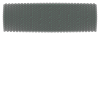

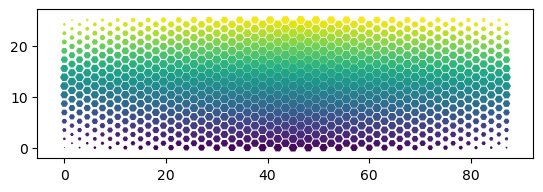

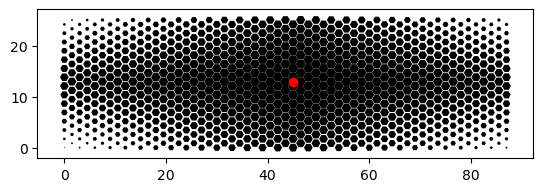

In [163]:
def createHexGrid(
        nrows:int=12, 
        ncols:int=6, 
        gap=0.1, 
        angle:float=45, 
        scale:float=1, 
        origin:tuple=(0,0), 
        plot:bool=True
        ) -> MultiPolygon:
    ox,oy=origin
    w,h=(scale*2,scale*3**.5)
    c_x, c_y = (0,0)
    fill = 1-gap

    center_point = Point(origin[0]+ncols*3/4*w, origin[1]+nrows/4*h)
    
    x_step = .75*w
    y_step = .5*h
    

    hxs = []
    for i in range(nrows):
        for j in range(ncols):
            if not (i%2==1 and j == ncols-1): 
                xoff = j*2*x_step+int(i%2==1)*x_step
                yoff = i*y_step
                
                fill = (1-gap)**(1+i/nrows+j/ncols)**2
                fill = (1-gap)**((2-abs(nrows/2-i)/nrows-abs(ncols/2-j)/ncols)**3)
                fill = (1-gap)**((1+abs(nrows/2-i)/nrows+abs(ncols/2-j)/ncols)**3)
                fill = (1-0.6*(abs(nrows/2-i)/nrows*abs(ncols/2-j)/ncols+abs(nrows/2-i)/nrows+abs(ncols/2-j)/ncols)**2)**(.8)
                
                hx = Polygon([
                    (xoff+ c_x-fill*.25*w, yoff+ c_y-fill*0.5*h),
                    (xoff+ c_x+fill*.25*w, yoff+ c_y-fill*0.5*h),
                    (xoff+ c_x+fill*.50*w, yoff+ c_y+fill*0.0*h),
                    (xoff+ c_x+fill*.25*w, yoff+ c_y+fill*0.5*h),
                    (xoff+ c_x-fill*.25*w, yoff+ c_y+fill*0.5*h),
                    (xoff+ c_x-fill*.50*w, yoff+ c_y+fill*0.0*h)
                    ])   
                hxs.append(hx)
    
    multipoly = gpd.GeoSeries(hxs).unary_union
    multipoly = rotate(multipoly, angle)

    if plot:
        gpd.GeoSeries(hxs).plot(cmap='viridis')
        fig, ax = plt.subplots()
        gpd.GeoSeries([multipoly]).plot(ax=ax,color='black')
        gpd.GeoSeries([center_point]).plot(ax=ax,color='red')
    return multipoly

createHexGrid(
    nrows=30, ncols=30, angle=0)

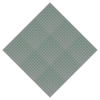

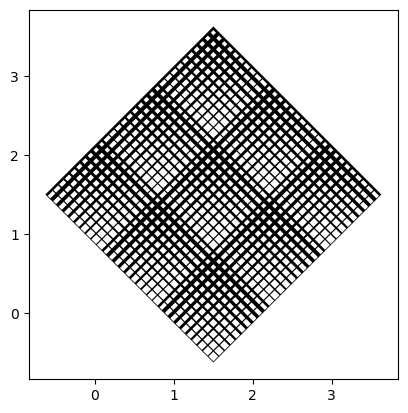

In [93]:
# from shapely.geometry import Polygon, MultiPolygon
# from shapely.affinity import translate, rotate
# import geopandas as gpd

# create grid with repeating increasing width
def create_grid(
        angle:float=45, 
        scale:float=1,
        origin:tuple=(0,0), 
        nreps_h:int=3, 
        nreps_v:int=3, 
        ncols:int=11, 
        nrows:int=11, 
        plot:bool=True
        )->MultiPolygon:
    dx,dy = 1*scale,1*scale
    w=0.01
    lines = []
    def get_thickness (n,N,w=w):
        return w*(1+5*n/N)
    
    for k in range(nreps_h):
        for n in range(nreps_v):
            for i in range(ncols):
                prg = i/(ncols-1)
                thickness = get_thickness(i, ncols)
                x1 = min(prg+.5*thickness, 1+.5*w)*dx
                x2 = max(prg-.5*thickness, (i-1)/(ncols-1))*dx
                lines.append(Polygon([
                    (x1+k*dx, (1+.5*w)*dy+n*dx),
                    (x1+k*dx, (0-.5*w)*dy+n*dx),
                    (x2+k*dx, (0-.5*w)*dy+n*dx),
                    (x2+k*dx, (1+.5*w)*dy+n*dx)
                    ]))
                
            for j in range(nrows): 
                prg = j/(nrows-1)
                thickness = get_thickness(j, nrows)
                y1 = max(prg-.5*thickness, 0-.5*w)*dy
                y2 = min(prg+.5*thickness, 1+.5*w)*dy
                lines.append(Polygon([
                    ((0-.5*w)*dx+k*dx, y1+n*dy),
                    ((1+.5*w)*dx+k*dx, y1+n*dx),
                    ((1+.5*w)*dx+k*dx, y2+n*dx),
                    ((0-.5*w)*dx+k*dx, y2+n*dx)
                    ]))
            
            
    poly = gpd.GeoSeries(lines).unary_union
    poly = rotate(poly,angle)

    if plot:
        # gpd.GeoSeries(lines).plot(cmap='viridis', alpha=.5)
        gpd.GeoSeries([poly]).plot(color='black')
    
    return poly
create_grid()

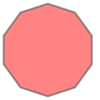

In [192]:
 Polygon([(.2*math.sin((i+1)/n * 360 * math.pi / 180 ), .2*math.cos((i+1)/n * 360 * math.pi / 180 ))
        for i in range(12)])

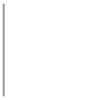

In [233]:
i=0
Polygon([
        (
            0-width*.5*math.sin((i/n+5) * 360 * math.pi / 180 ),
            0-width*.5*math.cos((i/n+5) * 360 * math.pi / 180 )),
        (
            0+width*.5*math.sin((i/n+.5) * 360 * math.pi / 180 ),
            0+width*.5*math.cos((i/n+.5) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )+width*.5*math.sin((i/n+.5) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )+width*.5*math.cos((i/n+.5) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )-width*.5*math.sin((i/n+.5) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )-width*.5*math.cos((i/n+.5) * 360 * math.pi / 180 )),
        ])

In [234]:
gpd.GeoSeries([Polygon([
        (
            0-width*.5*math.sin((i/n+5) * 360 * math.pi / 180 ),
            0-width*.5*math.cos((i/n+5) * 360 * math.pi / 180 )),
        (
            0+width*.5*math.sin((i/n+.5) * 360 * math.pi / 180 ),
            0+width*.5*math.cos((i/n+.5) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )+width*.5*math.sin((i/n+.5) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )+width*.5*math.cos((i/n+.5) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )-width*.5*math.sin((i/n+.5) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )-width*.5*math.cos((i/n+.5) * 360 * math.pi / 180 )),
        ]) for i in range(n)])

0    POLYGON ((0.00000 -0.05000, 0.00000 -0.05000, ...
1    POLYGON ((-0.02939 -0.04045, -0.02939 -0.04045...
2    POLYGON ((-0.04755 -0.01545, -0.04755 -0.01545...
3    POLYGON ((-0.04755 0.01545, -0.04755 0.01545, ...
4    POLYGON ((-0.02939 0.04045, -0.02939 0.04045, ...
5    POLYGON ((0.00000 0.05000, -0.00000 0.05000, 0...
6    POLYGON ((0.02939 0.04045, 0.02939 0.04045, -1...
7    POLYGON ((0.04755 0.01545, 0.04755 0.01545, -1...
8    POLYGON ((0.04755 -0.01545, 0.04755 -0.01545, ...
9    POLYGON ((0.02939 -0.04045, 0.02939 -0.04045, ...
dtype: geometry

<Axes: >

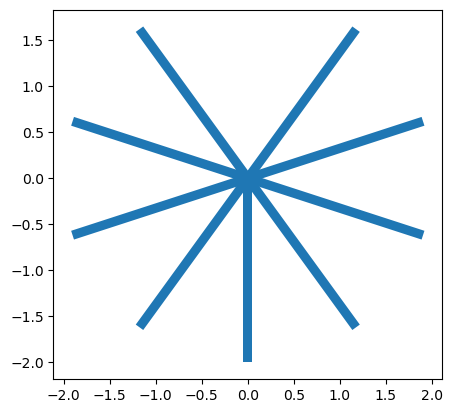

In [239]:
n=10
width=.1
gpd.GeoSeries([Polygon([
        (
            0-width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ),
            0-width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        (
            0+width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ),
            0+width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )+width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )+width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )-width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )-width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        ]) for i in range(n) if i>0]).plot()

<Axes: >

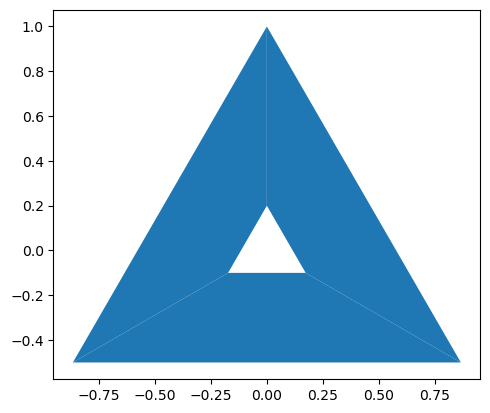

In [238]:
n = 3
gpd.GeoSeries([Polygon([
    (0,0),
    (math.sin(i/n * 360 * math.pi / 180 ), math.cos(i/n * 360 * math.pi / 180 )),
    (math.sin((i+1)/n * 360 * math.pi / 180 ), math.cos((i+1)/n * 360 * math.pi / 180 ))
    ]) for i in range(n)]).difference(
        Polygon([(.2*math.sin((i+1)/n * 360 * math.pi / 180 ), .2*math.cos((i+1)/n * 360 * math.pi / 180 ))
        for i in range(max(n,2))])
        ).plot()

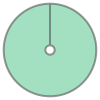

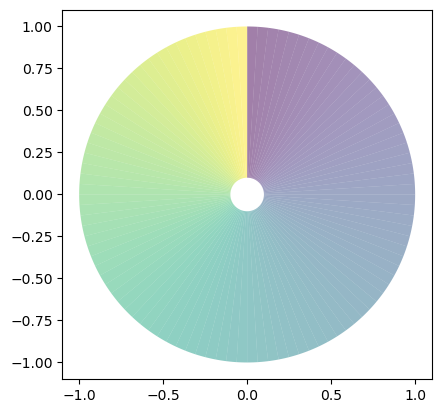

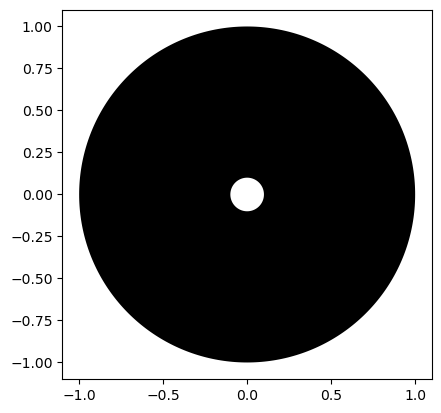

In [253]:
# from shapely.geometry import Polygon, MultiPolygon
# from shapely.affinity import translate, rotate
# import geopandas as gpd

# create grid with repeating increasing width
def create_slices(
        n:int=10, 
        circle:float=0.1,
        angle:float=0,
        plot:bool=True
        )->MultiPolygon:
    slices = [Polygon([
        (0,0),
        (2*math.sin(i/n * 360 * math.pi / 180 ), 2*math.cos(i/n * 360 * math.pi / 180 )),
        (2*math.sin((i+1)/n * 360 * math.pi / 180 ), 2*math.cos((i+1)/n * 360 * math.pi / 180 ))
        ]) for i in range(n)]
    
    gs = gpd.GeoSeries(slices)

    nc=max(n,360)
    crcl = Polygon(
        [(math.sin((i+1)/nc * 360 * math.pi / 180 ), math.cos((i+1)/nc * 360 * math.pi / 180 ))
        for i in range(nc)])
    gs = gs.intersection(crcl)

    if circle:
        crcl = Polygon(
            [(circle*math.sin((i+1)/nc * 360 * math.pi / 180 ), circle*math.cos((i+1)/nc * 360 * math.pi / 180 ))
            for i in range(nc)])
        gs = gs.difference(crcl)

    poly = gs.unary_union
    poly = rotate(poly,angle)
    poly.buffer(0)

    
    if plot:
        gs.plot(cmap='viridis', alpha=.5)
        gpd.GeoSeries([poly]).plot(color='black')
    
    return poly
create_slices(100,circle=0.1)

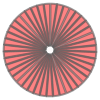

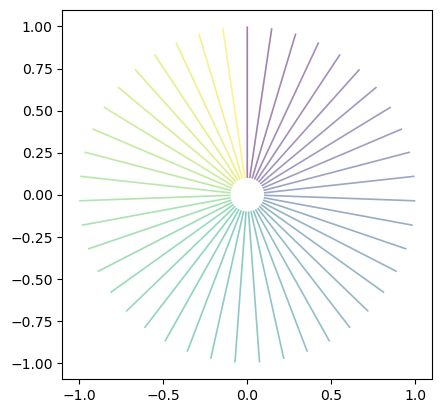

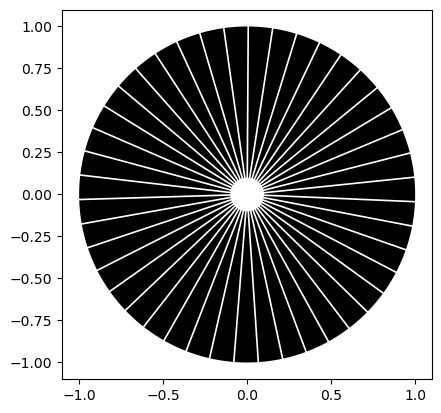

In [296]:
# from shapely.geometry import Polygon, MultiPolygon
# from shapely.affinity import translate, rotate
# import geopandas as gpd

# create grid with repeating increasing width
def create_rays(
        n:int=10, 
        diff:bool=False,
        circle:float=0.1,
        angle:float=0,
        width=.05,
        plot:bool=True
        )->MultiPolygon:
    slices = [Polygon([
        (0,0),
        (2*math.sin(i/n * 360 * math.pi / 180 ), 2*math.cos(i/n * 360 * math.pi / 180 )),
        (2*math.sin((i+1)/n * 360 * math.pi / 180 ), 2*math.cos((i+1)/n * 360 * math.pi / 180 ))
        ]) for i in range(n)]
    
    rays = [Polygon([
        (
            0-width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ),
            0-width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        (
            0+width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ),
            0+width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )+width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )+width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        (
            2*math.sin(i/n * 360 * math.pi / 180 )-width*.5*math.sin((i/n+.25) * 360 * math.pi / 180 ), 
            2*math.cos(i/n * 360 * math.pi / 180 )-width*.5*math.cos((i/n+.25) * 360 * math.pi / 180 )),
        ]) for i in range(n)]
    
    gs = gpd.GeoSeries(slices)
    gs = gpd.GeoSeries(rays)
    nc=max(n,360)
    crcl = Polygon(
        [(math.sin((i+1)/nc * 360 * math.pi / 180 ), math.cos((i+1)/nc * 360 * math.pi / 180 ))
        for i in range(nc)])
    gs = gs.intersection(crcl)
    # gs = gs.difference(crcl)
    
   
    
    if circle:
        crclInner = Polygon(
            [(circle*math.sin((i+1)/nc * 360 * math.pi / 180 ), circle*math.cos((i+1)/nc * 360 * math.pi / 180 ))
            for i in range(nc)])
        gs = gs.difference(crclInner)
        crcl = crcl.difference(crclInner)

    poly = gs.unary_union
    if diff: 
        poly = crcl.difference(poly)
    poly = rotate(poly,angle)
    poly.buffer(0)

    
    if plot:
        gs.plot(cmap='viridis', alpha=.5)
        gpd.GeoSeries([poly]).plot(color='black')
    
    return poly
create_rays(43, diff=True, circle=0.1, width=0.01, angle=8)

In [ ]:
# Remove strips from circle Combine 

<Axes: >

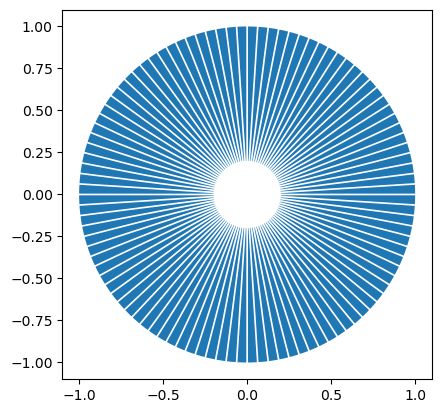

In [271]:
gpd.GeoSeries([
    create_slices(25,circle=0.2,plot=False).difference(create_rays(100,width=0.01,circle=0.,plot=False))
    ]).plot()

# Hummingbird

In [99]:
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon
import shapely
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
border = gpd.read_file('./hummingbird/layers/00border.shp')
cross = gpd.read_file('./hummingbird/layers/00cross.shp')
A1_hull = gpd.read_file('./hummingbird/layers/A1_hull.shp')
A1_blue = gpd.read_file('./hummingbird/layers/A2_blue.shp')
B1_black = gpd.read_file('./hummingbird/layers/B1_black.shp')
C1_brown_dark = gpd.read_file('./hummingbird/layers/C1_brown_dark.shp')
C2_green = gpd.read_file('./hummingbird/layers/C2_green.shp')
D1_brown_red = gpd.read_file('./hummingbird/layers/D1_brown_red.shp')
D2_teal = gpd.read_file('./hummingbird/layers/D2_teal.shp')
E1_white = gpd.read_file('./hummingbird/layers/E1_white.shp')


# Function to randomly adjust a form slightly

In [ ]:
LineString([(0,0),(0,1),(1,1),(1,0),(0,0)]).coords

In [ ]:


# Python3 code to demonstrate 
# to interleave lists 
# using zip() + itertools.chain() 
import itertools 
 
# initializing lists 
test_list1 = [1, 4, 5] 
test_list2 = [3, 8, 9] 
 
# printing original lists 
print ("Original list 1 : " + str(test_list1)) 
print ("Original list 2 : " + str(test_list2)) 
 
# using zip() + itertools.chain() 
# to interleave lists 
res = list(itertools.chain(*zip(test_list1, test_list2))) 
 
# printing result 
print ("The interleaved list is : " + str(res)) 

Original list 1 : [1, 4, 5]
Original list 2 : [3, 8, 9]
The interleaved list is : [1, 3, 4, 8, 5, 9]


In [ ]:
np.random.random(4)

array([0.36718386, 0.89610477, 0.33550015, 0.41446745])

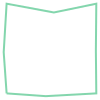

In [ ]:
def randomizeShape(LineStringRing=LineString([(0,0),(0,5),(5,5),(5,0),(0,0)]), maxDeviation=1, maxAngle=90):
    
    coords = LineStringRing.coords[:-1]

    return LineString(
        list(itertools.chain(*zip(
            coords, 
            [((x0+x1)*.5+r0-0.5,(y0+y1)*.5+r1-0.5) for (x0,y0),(x1,y1),r0,r1 in zip(
                coords,
                coords[1:]+coords[:1], 
                np.random.random(len(coords)), 
                np.random.random(len(coords))
            )]))) + LineStringRing.coords[-1:]
    )
randomizeShape()

In [ ]:
list(randomizeShape().coords)

[(0.0, 0.0),
 (0.3440593789780261, -0.38354140264700354),
 (0.0, 5.0),
 (-0.34567871551423546, 4.757445671070886),
 (5.0, 5.0),
 (5.485698994727806, 5.055817123890267),
 (5.0, 0.0),
 (2.9884414470678484, -0.09665345474938836),
 (0.0, 0.0)]

In [ ]:
from IPython.display import SVG
import os
mySVG = '<svg  xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><rect x="10" y="10" height="100" width="100" style="stroke:#ff0000; fill: #0000ff"/></svg>'
f1=open("testImage.svg", 'w+')
print(f1,mySVG)
f1.close()
os.popen("inkscape -z -e testImage.png -w 1024 -h 1024 testImage.svg")

<_io.TextIOWrapper name='testImage.svg' mode='w+' encoding='utf-8'> <svg  xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><rect x="10" y="10" height="100" width="100" style="stroke:#ff0000; fill: #0000ff"/></svg>


In [ ]:
from IPython.display import SVG
import os
mySVG = 'C:/Users/BSE/Downloads/Path 0.svg'
f1=open("C:/Users/BSE/Downloads/Path 0.svg", 'w+')
print(f1,mySVG)
f1.close()
os.popen("inkscape -z -e C:/Users/BSE/Downloads/Path 0.svg -w 1024 -h 1024 testImage.svg")

<_io.TextIOWrapper name='C:/Users/BSE/Downloads/Path 0.svg' mode='w+' encoding='utf-8'> C:/Users/BSE/Downloads/Path 0.svg


In [ ]:
os.popen("inkscape -z -e testImage.png -w 1024 -h 1024 testImage.svg")

In [ ]:
mySVG

'C:/Users/BSE/Downloads/Path 0.svg'

In [ ]:
pdf=gpd.read_file('C:/Users/BSE/Downloads/Path 0.pdf')

DriverError: 'C:/Users/BSE/Downloads/Path 0.pdf' not recognized as being in a supported file format.

In [ ]:
dxf=gpd.read_file('C:/Users/BSE/Downloads/Path 0.dxf')

In [ ]:
dxf.head()

,Layer,PaperSpace,SubClasses,Linetype,EntityHandle,Text,geometry
0,None,None,None,None,None,None,"LINESTRING (0.000 9182.500, 0.000 9173.000)"
1,None,None,None,None,None,None,"LINESTRING (0.000 9173.000, 0.421 9172.904, 0...."
2,None,None,None,None,None,None,"LINESTRING (8.000 9173.147, 8.134 9173.226, 8...."
3,None,None,None,None,None,None,"LINESTRING (11.735 9177.043, 11.800 9177.179, ..."
4,None,None,None,None,None,None,"LINESTRING (12.985 9184.250, 12.985 9184.504, ..."


In [ ]:
len(list(dxf['geometry'].loc[0].coords))

2

In [ ]:
dxf_2 =dxf[dxf['geometry'].apply(lambda x: len(list(x.coords)))==2]
dxf_32 =dxf[dxf['geometry'].apply(lambda x: len(list(x.coords)))==32]


<Axes: >

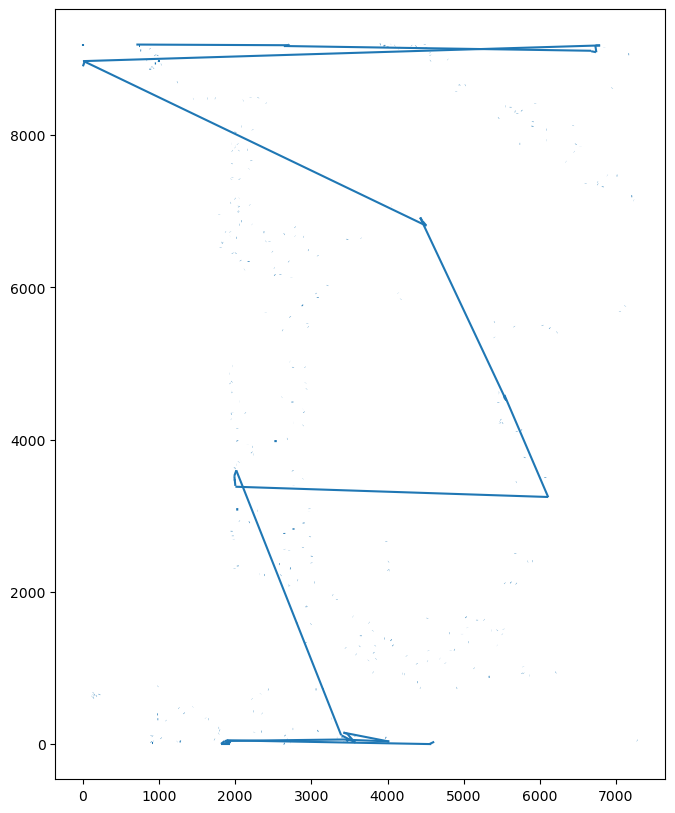

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
dxf_2.plot(ax=ax)

<Axes: >

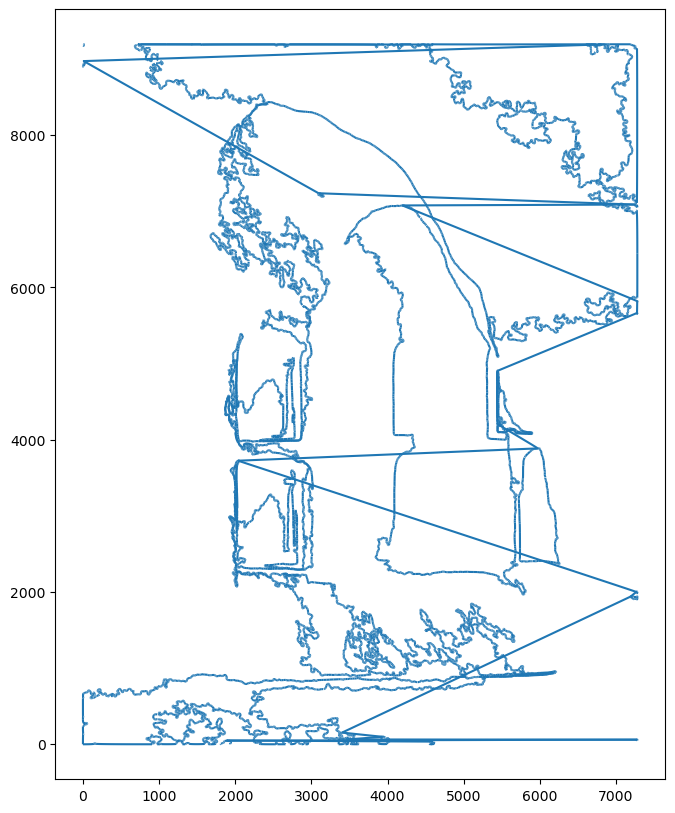

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
dxf_32.plot(ax=ax)

In [ ]:
dxf_32

,Layer,PaperSpace,SubClasses,Linetype,EntityHandle,Text,geometry
1,None,None,None,None,None,None,"LINESTRING (0.000 9173.000, 0.421 9172.904, 0...."
2,None,None,None,None,None,None,"LINESTRING (8.000 9173.147, 8.134 9173.226, 8...."
3,None,None,None,None,None,None,"LINESTRING (11.735 9177.043, 11.800 9177.179, ..."
4,None,None,None,None,None,None,"LINESTRING (12.985 9184.250, 12.985 9184.504, ..."
5,None,None,None,None,None,None,"LINESTRING (12.500 9190.500, 12.460 9190.606, ..."
...,...,...,...,...,...,...,...
17712,None,None,None,None,None,None,"LINESTRING (4563.750 9.106, 4563.549 9.207, 45..."
17713,None,None,None,None,None,None,"LINESTRING (4558.000 11.000, 4557.892 10.997, ..."
17717,None,None,None,None,None,None,"LINESTRING (4552.285 3.227, 4552.381 2.921, 45..."
17718,None,None,None,None,None,None,"LINESTRING (4608.546 5.038, 4608.654 5.515, 46..."


In [ ]:
dxf['geometry'].apply(lambda x: len(list(x.coords))).unique()

array([ 2, 32], dtype=int64)